# Testing bounding box conversion & IOU

* Code partially taken from [Oriented RepPoints](https://github.com/LiWentomng/OrientedRepPoints/tree/main/mmdet/ops).

In [312]:
%reload_ext autoreload
%autoreload 2

import time
import torch
import random
import matplotlib.pyplot as plt
from matplotlib import patches
from math import pi
from obb.utils.box_ops import *

### Generating random point clusters

In [29]:
def gen_random_clusters(num_clusters=10, points_per_cluster=9, im_dim=(256, 256), cluster_dim=(40, 40)):
    """ Generates a [B, N, 2] tensor with B clusters, N points each."""

    x_im, y_im = im_dim
    x_cluster, y_cluster = cluster_dim

    # Generate random centers
    x0_lst = torch.randint(0, x_im, (num_clusters,))
    y0_lst = torch.randint(0, y_im, (num_clusters,))

    # Generate random angles uniformly-distributed in the interval [-0.5*pi,0.5*pi)
    theta_lst = torch.rand((num_clusters,)) * pi - 0.5 * pi
    c_lst = torch.cos(theta_lst)
    s_lst = torch.sin(theta_lst)

    # Generate random cluster dimensions
    x_scale_lst = torch.randint(5, x_cluster, (num_clusters,))
    y_scale_lst = torch.randint(5, y_cluster, (num_clusters,))

    # Generate the random points for each cluster
    point_lst = []

    for x0, y0, c, s, x_scale, y_scale in zip(x0_lst, y0_lst, c_lst, s_lst, x_scale_lst, y_scale_lst):
        # Generate random offsets
        dx = torch.randint(0, x_scale, (points_per_cluster,))
        dy = torch.randint(0, y_scale, (points_per_cluster,))

        # Apply rotation
        dx_rot = c * dx - s * dy
        dy_rot = s * dx + c * dy

        points = torch.stack([x0 + dx_rot, y0 + dy_rot], dim=1) # [N, 2]
        point_lst.append(points)

    return torch.stack(point_lst) # [B, N, 2]

### Computing convex hull

Cluster tensor shape: torch.Size([40, 9, 2])
Elapsed time: 0.00 sec
Convex hull tensor shape: torch.Size([40, 9, 2])
Size tensor shape: torch.Size([40])


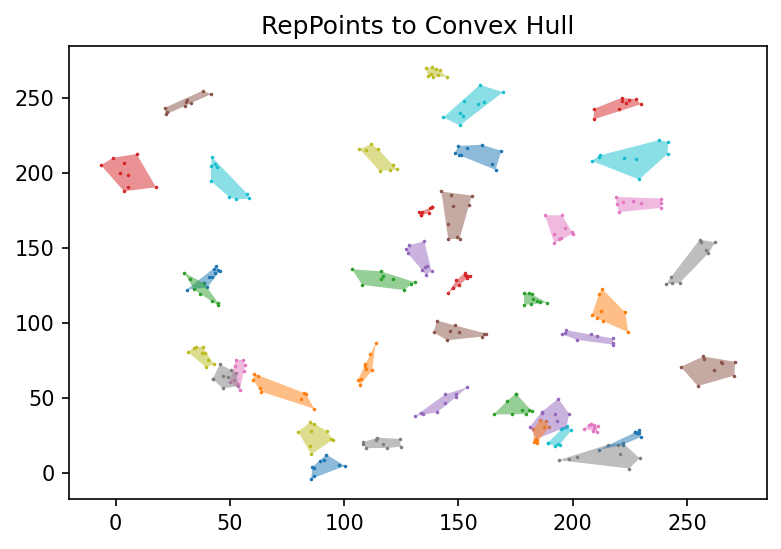

In [224]:
clusters = gen_random_clusters(num_clusters=40)
print(f'Cluster tensor shape: {clusters.shape}')

t0 = time.process_time()
hull, sizes = convex_hull(clusters)
t1 = time.process_time()
dt = t1 - t0

print(f'Elapsed time: {dt:.2f} sec')
print(f'Convex hull tensor shape: {hull.shape}')
print(f'Size tensor shape: {sizes.shape}')

fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.add_subplot(1, 1, 1)

for cluster in clusters:
    sc = ax.scatter(cluster[:, 0], cluster[:, 1], s=0.5)

for cluster, size in zip(hull, sizes):
    ax.fill(cluster[:size, 0], cluster[:size, 1], alpha=0.5)

plt.title('RepPoints to Convex Hull')
plt.show()

### Finding bounding rectangle with minimal area

Elapsed time: 0.00 sec
Minimal bounding rectangle shape: torch.Size([40, 4, 2])


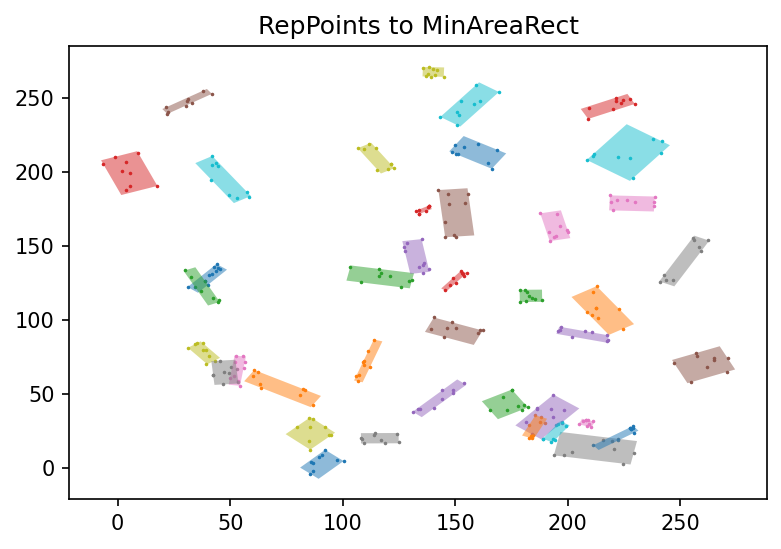

In [225]:
t0 = time.process_time()
rects = min_area_rect(clusters)
t1 = time.process_time()
dt = t1 - t0

print(f'Elapsed time: {dt:.2f} sec')
print(f'Minimal bounding rectangle shape: {rects.shape}')

fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.add_subplot(1, 1, 1)

for cluster in clusters:
    sc = ax.scatter(cluster[:, 0], cluster[:, 1], s=0.5)

for rect in rects:
    ax.fill(rect[:, 0], rect[:, 1], alpha=0.5)

plt.title('RepPoints to MinAreaRect')
plt.show()

### Testing out-of-box loss

Rectangle points: tensor([[39.9291,  9.7501],
        [39.2776, 12.5025],
        [37.2133, 12.0138],
        [37.8648,  9.2615]])
Outlier points: tensor([[39.4770, 14.7296],
        [43.4061, 13.4797],
        [40.6538, 12.8282],
        [40.2548,  8.3739],
        [41.6310,  8.6997]])
Distances: tensor([2.2361, 4.2426, 1.4142, 1.4142, 2.0000])


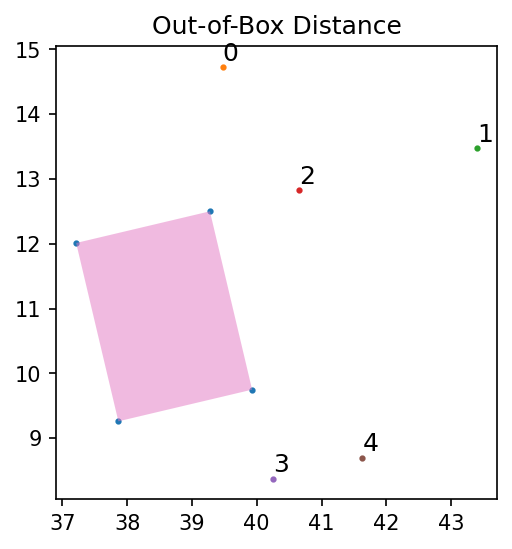

In [416]:
N = 1
B = 5

clusters = gen_random_clusters(num_clusters=N, points_per_cluster=B+4, im_dim=(40, 40), cluster_dim=(10, 10))
polys, points = clusters[..., :4, :], clusters[..., 4:, :]
rects = min_area_rect(polys).squeeze()
points = points.squeeze()
distances = torch.sqrt(out_of_box_distance(points, rects))

print(f'Rectangle points: {rects}')
print(f'Outlier points: {points}')
print(f'Distances: {distances}')

fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.add_subplot(1, 1, 1)

ax.scatter(rects[:, 0], rects[:, 1], s=4)
for i in range(B):
    ax.scatter(points[i, 0], points[i, 1], s=4)
    ax.text(points[i, 0], points[i, 1] + 0.1, i, fontsize=12)
ax.fill(rects[:, 0], rects[:, 1], alpha=0.5)

ax.set_aspect('equal', 'box')

plt.title('Out-of-Box Distance')
plt.show()